# Calculate path propagation/attenuation according to ITU-R P.452 (16)

## License

```
Calculate path propagation/attenuation according to ITU-R P.452 (16).
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
from collections import namedtuple, OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.utils.console import ProgressBar
from pycraf import pathprof
from pycraf import conversions as cnv

With pycraf it is very easy to query SRTM data for arbitrary positions. However, you will need to have to download such SRTM data, either in advance or during your session. Please see the [documentation](https://bwinkel.github.io/pycraf/pathprof/working_with_srtm.html) for more details.

Use the following, if you already have the SRTMDATA environment variable set, but not downloaded any ".hgt" files so far.

In [3]:
pathprof.SrtmConf.set(download='missing', server='viewpano')

<MultiState SrtmConf>

If you neither have the environment variable set nor ".hgt" files downloaded (you can use any target directory, of course):

In [8]:
# pathprof.SrtmConf.set(download='missing', server='viewpano', srtm_dir='.')

## Generating path propagation loss maps

Often it is desired to generate maps of path attenuation values, e.g., to
quickly determine regions where the necessary separations between a
potential interferer and the victim terminal would be too small, potentially
leading to radio frequency interference (RFI).

### Simple approach
Lets create a map of the region around the Effelsberg 100-m radio telescope in Germany.

In [4]:
lon_tx, lat_tx = 6.88361 * u.deg, 50.52483 * u.deg
map_size_lon, map_size_lat = 2. * u.deg, 2. * u.deg
map_resolution = 3. * u.arcsec

Note, that the radio telescope is the victim service, but to have it in the center of the map, we make use of the symmetric nature of the path propagation calculations and just use the geographic location of the telescope as transmitter location in `pycraf`.

Lets first plot the terrain, to get an idea of the local environment.

In [5]:
lons, lats, heightmap = pathprof.srtm_height_map(
    lon_tx, lat_tx,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution
    )

In [6]:
Site = namedtuple('site', ['name', 'coord', 'pixoff', 'color'])
sites = OrderedDict([
    # ID: tuple(Name, (lon, lat), Type, height, diameter, (xoff, yoff), color)
    ('100-m RT', Site('100-m RT', (6.88361, 50.52483), (20, +30), 'k')),
    ('Cologne', Site('Cologne', (6.9602, 50.9377), (-60, -10), 'k')),
    ('Bonn', Site('Bonn', (7.0982, 50.7375), (-30, 30), 'k')),
    ('Düsseldorf', Site('Düsseldorf', (6.7734, 51.2278), (-50, +20), 'k')),
    ('Leverkusen', Site('Leverkusen', (7.0192, 51.0460), (-35, +25), 'k')),
    ('Bergisch-Gladbach', Site('Bergisch-Gladbach', (7.1286, 50.9924), (+30, +30), 'k')),
    ('Dortmund', Site('Dortmund', (7.3301811, 51.5078011), (+10, -20), 'k')),
    ('Frankfurt', Site('Frankfurt', (8.4964822, 50.1211277), (-30, -30), 'k')),
    ('Eindhoven', Site('Eindhoven', (5.3814711, 51.4455368), (30, -30), 'k')),
    ('Liege', Site('Liège', (5.5290508, 50.6246191), (-30, -30), 'k')),
    ('Aachen', Site('Aachen', (6.0780895, 50.7739559), (-40, +20), 'k')),
    ])

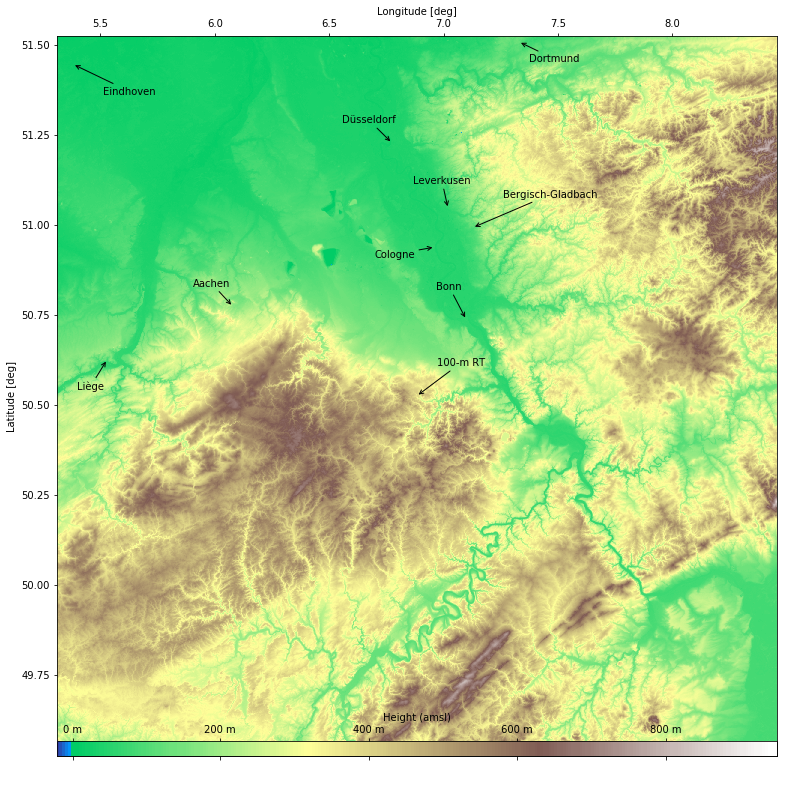

In [7]:
_lons = lons.to(u.deg).value
_lats = lats.to(u.deg).value
_heightmap = heightmap.to(u.m).value

vmin, vmax = -20, 950
terrain_cmap, terrain_norm = pathprof.terrain_cmap_factory(sealevel=0.5, vmax=vmax)
_heightmap[_heightmap < 0] = 0.51  # fix for coastal region

plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _heightmap,
    origin='lower', interpolation='nearest',
    cmap=terrain_cmap, norm=terrain_norm,
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Height (amsl)', color='k')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = True
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(0, 1350, 200)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} m'.format, ctics), color='k')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

for site_id, site in sites.items():
    color = site.color
    color = 'k'
    ax.annotate(
        site.name, xy=site.coord, xytext=site.pixoff, 
        textcoords='offset points', color=color,
        arrowprops=dict(arrowstyle="->", color=color)
        )

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

As one can see, the telescope is situated in a valley, but not too far away from the Cologne-Bonn region.

Now, we could of course calculate the path attenuation for each pixel in the map (relative to the telescope position). But this is really slow, such that we show this for a smaller area with lower spatial resolution, only. We will see later, how one can use a faster algorithm that works with larger maps sizes.

In [8]:
map_size_lon, map_size_lat = 0.5 * u.deg, 0.5 * u.deg
map_resolution = 15. * u.arcsec

lons, lats, heightmap = pathprof.srtm_height_map(
    lon_tx, lat_tx,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution
    )

Note, that the terrain map itself is not directly useful for path propagation loss calculation, as one has to still calculate the Geodesics between each pixel and the telescope position (which is a time-consuming calculation).

Now we make use of the standard pycraf methods to calculate path loss:

In [9]:
freq = 1. * u.GHz
omega = 0. * u.percent  # fraction of path over sea
temperature = 290. * u.K
pressure = 1013. * u.hPa
timepercent = 2 * u.percent  # see P.452 for explanation
h_tg, h_rg = 50 * u.m, 10 * u.m
G_t, G_r = 0 * cnv.dBi, 0 * cnv.dBi
zone_t, zone_r = pathprof.CLUTTER.UNKNOWN, pathprof.CLUTTER.UNKNOWN
hprof_step = 100 * u.m

atten_map = np.zeros(
    lats.shape + lons.shape, 
    dtype=np.dtype([
        ('LOS', 'f8'), ('Diffraction', 'f8'), ('Troposcatter', 'f8'), 
        ('Ducting', 'f8'), ('Total', 'f8'),
        ('Total w. clutter', 'f8'), ('Total w. clutter/gain', 'f8')
        ])
    )


In [10]:
for i in ProgressBar(range(atten_map.shape[1]), ipython_widget=True):
    for j in range(atten_map.shape[0]):

        # Create PathProp object
        try:
            pprop = pathprof.PathProp(
                freq,
                temperature, pressure,
                lon_tx, lat_tx,
                lons[i], lats[j],
                h_tg, h_rg,
                hprof_step,
                timepercent,
                zone_t=zone_t, zone_r=zone_r,
                )
        except ValueError:
            # height profile must have at least 5 steps, which may
            # be violated for central pixel
            continue

        # Calculate loss
        tot_loss = pathprof.loss_complete(pprop, G_t, G_r)
        atten_map[j, i] = u.Quantity(tot_loss).value

FloatProgress(value=0.0)

In [20]:
cnv.dB_1_m

Unit("dB(1 / m)")

AttributeError: 'numpy.ndarray' object has no attribute 'to'

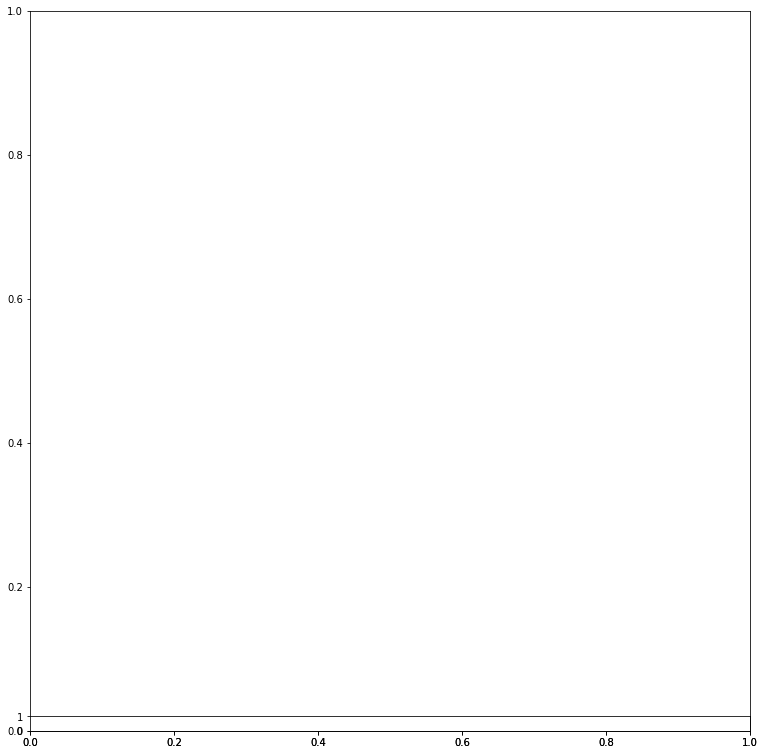

In [14]:
_lons = lons.to(u.deg).value
_lats = lats.to(u.deg).value
_total_atten = atten_map['Total']

vmin, vmax = -5, 175

plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _total_atten.to(cnv.dB).value,
    origin='lower', interpolation='nearest', cmap='inferno_r',
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Path propagation loss', color='w')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = True
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(0, 300, 20)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

for site_id, site in sites.items():
    color = site.color
    color = 'w'
    ax.annotate(
        site.name, xy=site.coord, xytext=site.pixoff, 
        textcoords='offset points', color=color,
        arrowprops=dict(arrowstyle="->", color=color)
        )

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

### Fast approach
We will now produce the same map with much higher resolution but still reasonably fast. The idea is to generate the full height profiles only for the pixels on the map edges and re-use the arrays for the inner pixels with a clever hashing algorithm. The details of this are encapsulated in the `height_map_data` function, such that the user doesn't need to understand what's going on under the hood:

In [11]:
map_resolution = 3. * u.arcsec

In [18]:
hprof_cache = pathprof.height_map_data(
    lon_tx, lat_tx,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution,
    zone_t=zone_t, zone_r=zone_r,
    )

In [19]:
results = pathprof.atten_map_fast(
    freq,
    temperature,
    pressure,
    h_tg, h_rg,
    timepercent,
    hprof_cache,  # dict_like
    )

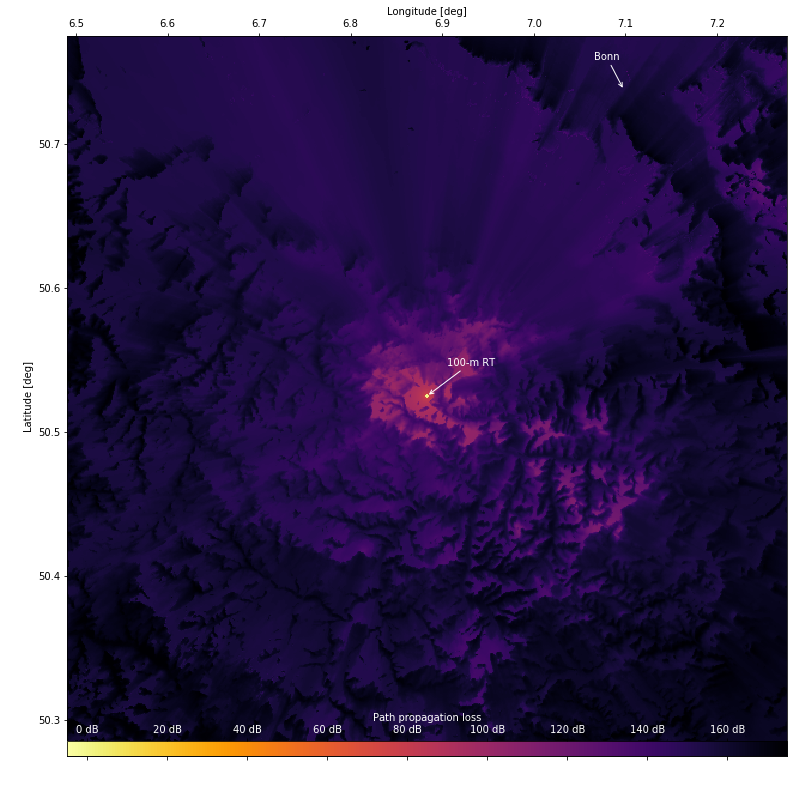

In [20]:
_lons = hprof_cache['xcoords']
_lats = hprof_cache['ycoords']
_total_atten = results['L_b']  # see description of atten_map_fast

vmin, vmax = -5, 175

plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _total_atten.to(cnv.dB).value,
    origin='lower', interpolation='nearest', cmap='inferno_r',
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Path propagation loss', color='w')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = True
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(0, 300, 20)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

for site_id, site in sites.items():
    color = site.color
    color = 'w'
    ax.annotate(
        site.name, xy=site.coord, xytext=site.pixoff, 
        textcoords='offset points', color=color,
        arrowprops=dict(arrowstyle="->", color=color)
        )

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()